In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


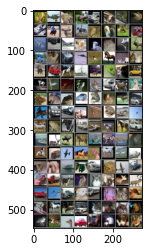

frog  plane frog  car   car   frog  frog  frog  ship  horse deer  horse bird  dog   deer  car   plane bird  plane dog   truck dog   cat   deer  truck dog   car   plane bird  horse cat   bird  deer  truck horse ship  deer  frog  cat   car   horse bird  cat   bird  dog   truck horse bird  frog  cat   frog  car   frog  bird  deer  car   frog  car   truck truck deer  frog  ship  plane horse frog  cat   car   plane horse horse car   ship  deer  bird  horse ship  frog  ship  bird  horse truck plane horse bird  horse plane plane cat   dog   ship  cat   car   frog  plane truck car   truck dog   cat   cat   truck deer  deer  truck bird  truck dog   truck deer  cat   deer  dog   horse deer  car   cat   cat   cat   bird  frog  dog   bird  car   truck truck dog   bird 


In [ ]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(0.3) # Dropout 'p' value according to Wide ResNet paper

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = LambdaLayer(lambda x:
                                        F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
#WRD-10-4
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model = ResNet(BasicBlock, [1, 1, 1, 1]).to(device)

In [ ]:
# Calculate Total No. of Params and No. of Layers
def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.cpu().data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))

test(model)

Total number of params 4729418
Total layers 10


In [ ]:
num_epochs = 200
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
train_losses = []
def train(epoch):
  model.train()
  total_step = len(trainloader)
  running_loss = 0.0
  for i, (images, labels) in enumerate(trainloader):
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      if (i+1) % 100 == 0:
          print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  epoch_loss = running_loss / len(trainloader)
  train_losses.append(epoch_loss)

In [ ]:
# Test the model
test_losses = []
def test(epoch):
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      running_loss_test = 0.0
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)

          tloss = criterion(outputs, labels)
          running_loss_test += tloss.item()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  epoch_loss = running_loss_test / len(testloader)
  test_losses.append(epoch_loss)

  print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [ ]:
curr_lr = learning_rate
for epoch in range(num_epochs):
  train(epoch)
  # Decay learning rate
  if (epoch+1) % 20 == 0:
      curr_lr /= 3
      update_lr(optimizer, curr_lr)
  test(epoch)

Epoch [1/200], Step [100/391] Loss: 1.5552
Epoch [1/200], Step [200/391] Loss: 1.3073
Epoch [1/200], Step [300/391] Loss: 1.2127
Accuracy of the model on the test images: 49.62 %
Epoch [2/200], Step [100/391] Loss: 1.0533
Epoch [2/200], Step [200/391] Loss: 0.9142
Epoch [2/200], Step [300/391] Loss: 0.7920
Accuracy of the model on the test images: 67.75 %
Epoch [3/200], Step [100/391] Loss: 0.7780
Epoch [3/200], Step [200/391] Loss: 0.7780
Epoch [3/200], Step [300/391] Loss: 0.9329
Accuracy of the model on the test images: 70.74 %
Epoch [4/200], Step [100/391] Loss: 0.7269
Epoch [4/200], Step [200/391] Loss: 0.6054
Epoch [4/200], Step [300/391] Loss: 0.6775
Accuracy of the model on the test images: 75.88 %
Epoch [5/200], Step [100/391] Loss: 0.6167
Epoch [5/200], Step [200/391] Loss: 0.5974
Epoch [5/200], Step [300/391] Loss: 0.5760
Accuracy of the model on the test images: 77.84 %
Epoch [6/200], Step [100/391] Loss: 0.6261
Epoch [6/200], Step [200/391] Loss: 0.4857
Epoch [6/200], Step

Text(0, 0.5, 'Test Loss')

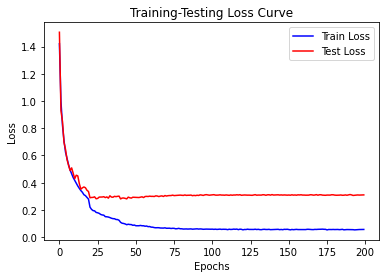

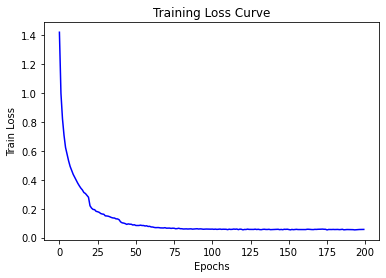

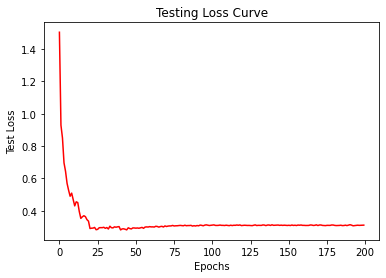

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(train_losses, 'b')
plt.plot(test_losses, 'r')
plt.legend(["Train Loss", "Test Loss"])
plt.title("Training-Testing Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.figure(2)
plt.plot(train_losses, 'b')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

plt.figure(3)
plt.plot(test_losses, 'r')
plt.title("Testing Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Test Loss")

In [ ]:
torch.save(model.state_dict(), "project1_model.pt")